# Mar-?-2021 (baselines)

**Motivation**: Overlapping communities.<br>

In [1]:
# HIDE CODE


# generic imports
import re
import os
import sys
import random
import itertools
import collections
import numpy as np
import pandas as pd
import networkx as nx
import nibabel as nib
from pprint import pprint
from scipy import signal
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from os.path import join as pjoin
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import patches
from matplotlib import cm
import seaborn as sns
sns.set_style('white')


# Filter warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# nx imports
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.classes.function import density

# Louvain etc
import community as community_louvain
from cdlib import algorithms

# network measures
from networkx.algorithms.cluster import transitivity, average_clustering
from networkx.algorithms.assortativity import degree_pearson_correlation_coefficient
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency
from networkx.algorithms.approximation.clique import large_clique_size
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
from networkx.algorithms.smallworld import sigma, omega

# Dirs
base_dir = pjoin(os.environ['HOME'], 'Documents/data')
raw_dir = pjoin(base_dir, 'raw')
processed_dir = pjoin(base_dir, 'processed')

# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from utils.plotting import *
from utils.processing import *
from model.configuration import ProcessConfig


# fix random stete
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
rng = np.random.RandomState(RANDOM_STATE)

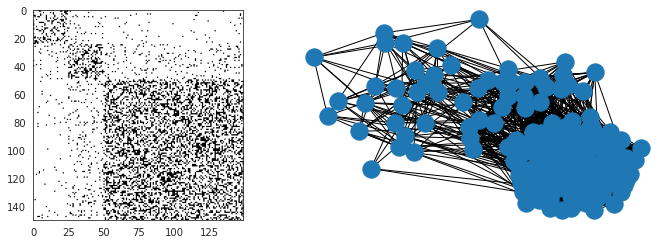

In [2]:
sizes = [25, 25, 100]
probs = [[0.25, 0.05, 0.02], [0.05, 0.35, 0.07], [0.02, 0.07, 0.40]]
g = nx.stochastic_block_model(
    sizes=sizes,
    p=probs,
    seed=RANDOM_STATE,
)
a = nx.adjacency_matrix(g).toarray()

plt.figure(figsize=(10, 3.5))
plt.subplot(121)
plt.imshow(a, cmap='Greys')
plt.subplot(122)
nx.draw(g)
plt.tight_layout()
plt.show()

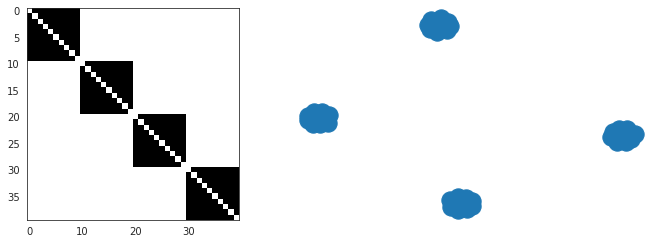

In [3]:
g = nx.caveman_graph(4, 10)
a = nx.adjacency_matrix(g).toarray()

plt.figure(figsize=(10, 3.5))
plt.subplot(121)
plt.imshow(a, cmap='Greys')
plt.subplot(122)
nx.draw(g)
plt.tight_layout()
plt.show()

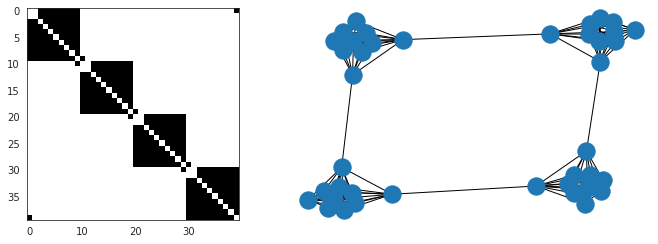

In [4]:
g = nx.connected_caveman_graph(4, 10)
a = nx.adjacency_matrix(g).toarray()

plt.figure(figsize=(10, 3.5))
plt.subplot(121)
plt.imshow(a, cmap='Greys')
plt.subplot(122)
nx.draw(g)
plt.tight_layout()
plt.show()

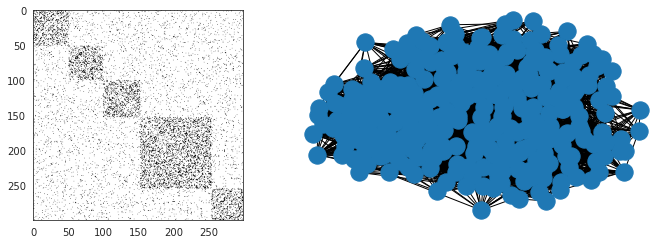

In [5]:
g = nx.gaussian_random_partition_graph(n=300, s=60, v=1, p_in=0.3, p_out=0.05, seed=RANDOM_STATE)
a = nx.adjacency_matrix(g).toarray()

plt.figure(figsize=(10, 3.5))
plt.subplot(121)
plt.imshow(a, cmap='Greys')
plt.subplot(122)
nx.draw(g)
plt.tight_layout()
plt.show()

## LFR

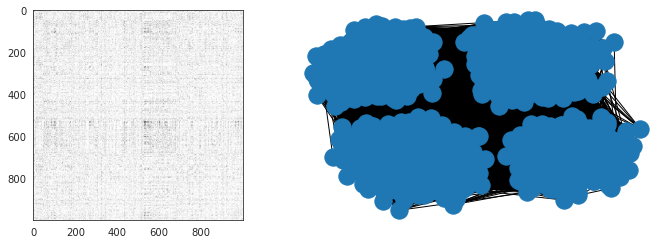

In [11]:
g = nx.LFR_benchmark_graph(
    n=1000,
    tau1=3,
    tau2=1.7,
    mu=0.1,
    average_degree=100,
    max_degree=300,
    min_community=200,
    # max_community=15,
    max_iters=500,
    seed=RANDOM_STATE,
)
a = nx.adjacency_matrix(g).toarray()

plt.figure(figsize=(10, 3.5))
plt.subplot(121)
plt.imshow(a, cmap='Greys')
plt.subplot(122)
nx.draw(g)
plt.tight_layout()
plt.show()

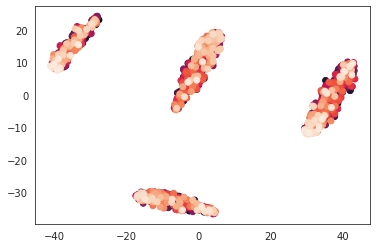

In [12]:
from karateclub import DeepWalk

model = DeepWalk(dimensions=32, learning_rate=0.01)
model.fit(g)
embedding = model.get_embedding()

import numpy as np
from sklearn.manifold import TSNE
x = TSNE(n_components=2, perplexity=50).fit_transform(embedding)

plt.scatter(x[:, 0], x[:, 1], c=range(len(x)))

In [13]:
communities = {frozenset(g.nodes[v]["community"]) for v in g}
nx.algorithms.community.community_utils.is_partition(g, communities)

True

In [14]:
communities_true = {idx: list(comm) for idx, comm in enumerate(communities)}
partition_true = {v: next(filter(lambda x: v in x[1], communities_true.items()))[0] for v in g}

len(communities_true)

4

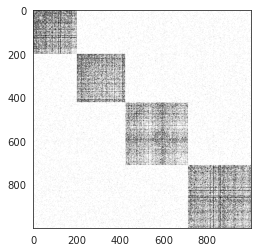

In [15]:
comm_indxs = np.concatenate(list(communities_true.values()))
plt.imshow(a[comm_indxs][:, comm_indxs], cmap='Greys')

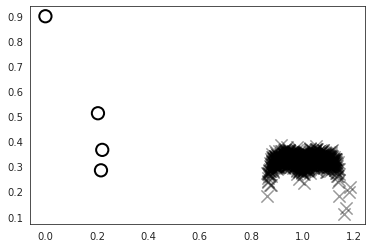

In [16]:
w, v = np.linalg.eigh(nx.normalized_laplacian_matrix(g).toarray())
ipr = 1 / np.power(v, 4).sum(0)
ipr /= len(ipr)
sort_indxs = np.argsort(w)

num_comm = len(communities_true)
plt.scatter(
    w[sort_indxs[num_comm:]], ipr[sort_indxs[num_comm:]],
    marker='x', color='k', s=150, alpha=0.4,
)
plt.scatter(
    w[sort_indxs[:num_comm]], ipr[sort_indxs[:num_comm]],
    marker='o', edgecolors='k', lw=2, color='none', s=150,
)

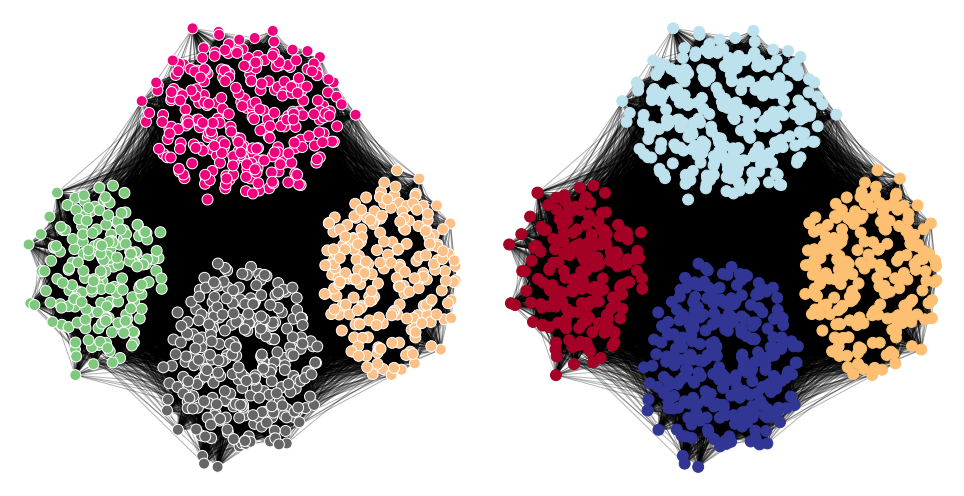

In [17]:
import networkx as nx
import community
import matplotlib.pyplot as plt

# G = nx.karate_club_graph()  # load a default graph
partition = community.best_partition(g)  # compute communities

pos = nx.spring_layout(g, iterations=1000)  # compute graph layout
plt.figure(figsize=(13.5, 7))

plt.subplot(121)
plt.axis('off')
nx.draw_networkx_nodes(g, pos, node_size=120, cmap='Accent', edgecolors='white', node_color=list(partition.values()))
nx.draw_networkx_edges(g, pos, alpha=0.3)

plt.subplot(122)
plt.axis('off')
nx.draw_networkx_nodes(g, pos, node_size=120, cmap='RdYlBu', node_color=list(partition_true.values()))
nx.draw_networkx_edges(g, pos, alpha=0.3)

plt.tight_layout()
plt.show()

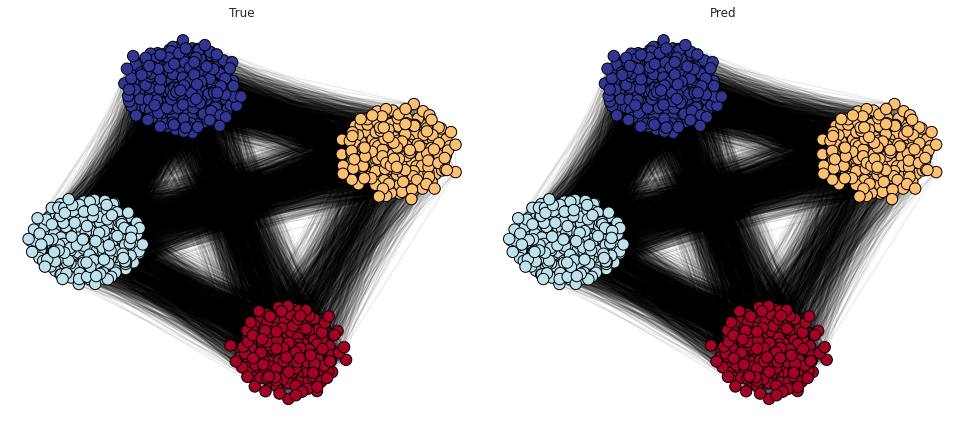

In [18]:
partition_louvain = community.best_partition(g, resolution=1.0, random_state=RANDOM_STATE)

plot_graph(g, partition_pred=partition_louvain, partition_true=partition_true, cmap='RdYlBu')

In [19]:
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_mutual_info_score

nmi = normalized_mutual_info_score(list(partition_true.values()), list(partition_louvain.values()))
ami = adjusted_mutual_info_score(list(partition_true.values()), list(partition_louvain.values()))

print('NMI: {:.4f}\nAMI: {:.4f}'.format(nmi, ami))

NMI: 1.0000
AMI: 1.0000
